In [55]:
library(ggplot2)
library(naturalsort)
library(stringr)
library(vcfR)
library(data.table)
library(dplyr)


Attaching package: 'dplyr'


The following objects are masked from 'package:data.table':

    between, first, last


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




In [33]:
df_coverage_chris<-fread("/home/ceberlein/02_ANALYSES/02_TRD/02_Coverage_AlleleFreq/Coverage_TRD_Scerevisiae.csv", data.table = FALSE)

In [111]:
vcfs=dir(path = "ceberlein_data", pattern="vcf.m2M3-snps.vcf.gz$", full.names = TRUE)
vcfs

[1] "ceberlein_data/1_ACPxBFP.vcf.m2M3-snps.vcf.gz"
[2] "ceberlein_data/2_BAPxCMP.vcf.m2M3-snps.vcf.gz"
[3] "ceberlein_data/3_CCDxCPG.vcf.m2M3-snps.vcf.gz"
[4] "ceberlein_data/4_ATExYCR.vcf.m2M3-snps.vcf.gz"
[5] "ceberlein_data/5_ACKxACV.vcf.m2M3-snps.vcf.gz"
[6] "ceberlein_data/6_AKExBAH.vcf.m2M3-snps.vcf.gz"
[7] "ceberlein_data/7_BAHxCGD.vcf.m2M3-snps.vcf.gz"
[8] "ceberlein_data/8_ANGxCEI.vcf.m2M3-snps.vcf.gz"

In [112]:
getCrossName=function(x){
  return(str_replace(str_split(basename(x),"_")[[1]][2], ".vcf.m2M3-snps.vcf.gz", ""))
}
getColsInGTfile=function(x){
    return(colnames(homozygous_gt)[grepl(x,colnames(homozygous_gt))])
}

I will generate figures with different subsets of the data of all VCFs.

In [132]:
getPart=function(x,which){
    if(is.na(x)){
        return(NA)
    }
    tmpsplit<-strsplit(x, split = ",", fixed = TRUE)[[1]]
    #print(as.numeric(tmpsplit))
    if(length(tmpsplit)==2)
        {
        return(as.numeric(tmpsplit[which]))
    }
    if(length(tmpsplit)==3)
        {
        if((as.numeric(tmpsplit[1])/(as.numeric(tmpsplit[1])+as.numeric(tmpsplit[2])+as.numeric(tmpsplit[3])))<0.05){
            return(NA)
        }
        return(as.numeric(tmpsplit[which+1]))
    }
    
    stop("Assumption about alleles wrong!")
}
getPartNumber=function(x){
    return(as.numeric(length(strsplit(x, split = ",", fixed = TRUE)[[1]])))
}
IsLocusInGoodRegion=function(x){
    return(sum(df$POS[x] >= filtered_regions$Start[filtered_regions$chrom==df$CHROM[x]] & 
               df$POS[x] <= filtered_regions$Stop[filtered_regions$chrom==df$CHROM[x]]))
}

In [133]:
for(v in vcfs)
    {
    getCrossName(v)

    vcf <- read.vcfR(v, verbose = FALSE )

    AD <- extract.gt(vcf, element = 'AD', as.numeric = FALSE)
    DP <- extract.gt(vcf, element = 'DP', as.numeric = TRUE)

    summary(getPartNumber(extract.gt(vcf, element = 'AD', as.numeric = FALSE)))

    AD1 = unlist(lapply(AD, getPart, which=1))
    AD2 = unlist(lapply(AD, getPart, which=2))

    AlleleFrequency=AD2/(AD1+AD2)

    MQ <- extract.info(vcf, element = 'MQ', as.numeric = TRUE)
    head(MQ)

    df=data.frame(POS=vcfR::getPOS(vcf), CHROM=vcfR::getCHROM(vcf), AF=AlleleFrequency, MQ=MQ, DP = DP)

    # scale pos
    for(c in unique(df$CHROM)){
        df$POS_scale[df$CHROM==c]=df$POS[df$CHROM==c]/max(df$POS[df$CHROM==c],na.rm=TRUE)
        df$MQ_scale[df$CHROM==c]=df$MQ[df$CHROM==c]-mean(df$MQ[df$CHROM==c],na.rm=TRUE)

        df$MQ_scale2[df$CHROM==c]=scale(df$MQ[df$CHROM==c])
    }

    ggplot(df, aes(POS_scale, AF))+
    geom_point(alpha=0.1)+
    facet_wrap(~CHROM)
    ggsave(filename = paste("figures/",getCrossName(v),"-AF.png",sep=""), width = 10, height= 10)

    ggplot(subset(df, MQ>=60), aes(POS_scale, AF))+
    geom_point(alpha=0.1)+
    facet_wrap(~CHROM)
    ggsave(filename = paste("figures/",getCrossName(v),"-AF-MQ60.png",sep=""), width = 10, height= 10)

    # filter for non-mean covered regions

    
    
    coverage_this_species=subset(df_coverage_chris, species==unique(df_coverage_chris$species)[which(grepl(getCrossName(v), unique(df_coverage_chris$species)))])
    
    coverage_range=as.numeric(quantile(subset(coverage_this_species, sub_window_mean_converage < 200)$sub_window_median_converage, c(0.1,0.9)))


    
    ggplot(subset(coverage_this_species, sub_window_mean_converage < 200), aes(sub_window_mean_converage))+
    geom_histogram()+
    geom_vline(xintercept = coverage_range, color="red")
    ggsave(filename = paste("figures/",getCrossName(v),"-coverage_below_200x.png",sep=""), width = 5, height= 5)

    filtered_regions=subset(coverage_this_species, sub_window_mean_converage>=coverage_range[1] & sub_window_mean_converage<=coverage_range[2])

    #summary(unlist(lapply(1:nrow(df), IsLocusInGoodRegion)))

    #hist(subset(df, MQ>=60 & AF > 0 & unlist(lapply(1:nrow(df), IsLocusInGoodRegion)) == 1)$AF)

    ggplot(subset(df, MQ>=60 & unlist(lapply(1:nrow(df), IsLocusInGoodRegion)) == 1), aes(POS_scale, AF))+
    geom_point(alpha=0.1)+
    facet_wrap(~CHROM)
    ggsave(filename = paste("figures/",getCrossName(v),"-AF-MQ60-cov",coverage_range[1],"_",coverage_range[2],".png",sep=""), width = 10, height= 10)

    
    ggplot(subset(df, MQ>=60 & unlist(lapply(1:nrow(df), IsLocusInGoodRegion)) == 1 & DP >= coverage_range[1]), aes(POS_scale, AF))+
    geom_point(alpha=0.1)+
    facet_wrap(~CHROM)
    ggsave(filename = paste("figures/",getCrossName(v),"-AF-MQ60-cov",coverage_range[1],"_",coverage_range[2],"-DP",coverage_range[1],".png",sep=""), width = 10, height= 10)


    
    colsGT=unlist(lapply(strsplit(getCrossName(v),"x")[[1]], getColsInGTfile))
    
    if(length(colsGT)>2){
        stop()
    }
    
    homozygous_gt=fread("./homozygous_gt.csv.gz", data.table=FALSE)
    homozygous_gt_cross=homozygous_gt[,c("POS","CHROM",colsGT)]
    gt=fread("./gt.csv.gz", data.table=FALSE)
    gt_cross=gt[,c("POS","CHROM",colsGT)]

    if(nrow(gt_cross)!=nrow(homozygous_gt_cross)){
        stop()
    }

    homozygous_gt_cross$OppositeHomo=!is.na(homozygous_gt_cross[,3]) & !is.na(homozygous_gt_cross[,4]) & homozygous_gt_cross[,3] == TRUE & homozygous_gt_cross[,4] == TRUE &
    gt_cross[,3] != gt_cross[,4]

    summary(homozygous_gt_cross$OppositeHomo)

    df=left_join(df, homozygous_gt_cross[,c("POS","CHROM","OppositeHomo")], by=c("POS","CHROM"))
    head(df)

    ggplot(subset(df, MQ>=60 & unlist(lapply(1:nrow(df), IsLocusInGoodRegion)) == 1 & DP >= coverage_range[1] & !is.na(OppositeHomo) & OppositeHomo == TRUE), aes(POS_scale, AF))+
    geom_point(alpha=0.1)+
    facet_wrap(~CHROM)
    ggsave(filename = paste("figures/",getCrossName(v),"-AF-MQ60-cov",coverage_range[1],"_",coverage_range[2],"-DP",coverage_range[1],"-OppositeHomo.png",sep=""), width = 10, height= 10)
    
    fwrite(subset(df, MQ>=60 & unlist(lapply(1:nrow(df), IsLocusInGoodRegion)) == 1 & DP >= coverage_range[1] & !is.na(OppositeHomo) & OppositeHomo == TRUE),
            paste("figures/",getCrossName(v),"-data-MQ60-cov",coverage_range[1],"_",coverage_range[2],"-DP",coverage_range[1],"-OppositeHomo.csv",sep=""))
}

Warning message:
"Removed 103 rows containing missing values (geom_point)."
Warning message:
"Removed 58 rows containing missing values (geom_point)."
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
"Removed 45 rows containing missing values (geom_point)."
Warning message:
"Removed 36 rows containing missing values (geom_point)."
Warning message:
"Removed 33 rows containing missing values (geom_point)."
Warning message:
"Removed 192 rows containing missing values (geom_point)."
Warning message:
"Removed 122 rows containing missing values (geom_point)."
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
"Removed 83 rows containing missing values (geom_point)."
Warning message:
"Removed 65 rows containing missing values (geom_point)."
Warning message:
"Removed 64 rows containing missing values (geom_point)."
Warning message:
"Removed 245 rows containing missing values (geom_point)."
Warning message:
"Removed 147 rows 

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



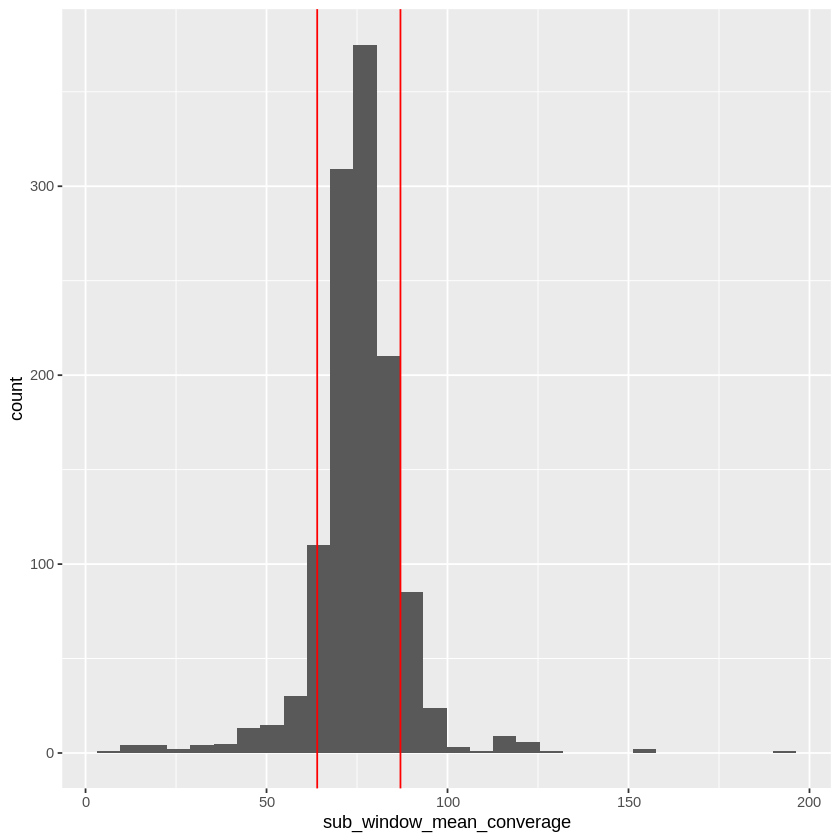

In [101]:
coverage_range=as.numeric(quantile(subset(coverage_this_species, sub_window_mean_converage < 200)$sub_window_median_converage, c(0.1,0.9)))


    
    ggplot(subset(coverage_this_species, sub_window_mean_converage < 200), aes(sub_window_mean_converage))+
    geom_histogram()+
    geom_vline(xintercept = coverage_range, color="red")

In [99]:
as.numeric(quantile(subset(coverage_this_species, sub_window_mean_converage < 200)$sub_window_median_converage, c(0.2,0.8)))

[1] 69 82

In [92]:
head(AF0_check<-subset(df, AF == 0 & MQ>=60 & unlist(lapply(1:nrow(df), IsLocusInGoodRegion)) == 1 & !is.na(OppositeHomo) & OppositeHomo == TRUE))

,POS,CHROM,AF,MQ,POS_scale,MQ_scale,MQ_scale2,OppositeHomo
,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>
12746,541559,chromosome2,0,63.72,0.6682341,4.5486225,0.9971329,TRUE
25936,169833,chromosome4,0,60.00,0.1113494,0.8396109,0.1908707,TRUE
28434,329661,chromosome4,0,60.00,0.2161391,0.8396109,0.1908707,TRUE
30489,449722,chromosome4,0,60.00,0.2948560,0.8396109,0.1908707,TRUE
45050,1353386,chromosome4,0,60.00,0.8873347,0.8396109,0.1908707,TRUE
51436,187817,chromosome5,0,60.00,0.3285007,0.5642582,0.1681734,TRUE


In [93]:
AF0_check=left_join(AF0_check, gt_cross[,c("POS","CHROM","ANG","CEI")])

Joining, by = c("POS", "CHROM")



In [94]:
summary(AF0_check$ANG == AF0_check$CEI)

   Mode   FALSE 
logical      24 

In [95]:
AF0_check[AF0_check$ANG != AF0_check$CEI,]

,POS,CHROM,AF,MQ,POS_scale,MQ_scale,MQ_scale2,OppositeHomo,ANG,CEI
,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<chr>,<chr>
1,541559,chromosome2,0,63.72,0.668234142,4.5486225,0.9971329,TRUE,1/1,0/0
2,169833,chromosome4,0,60.00,0.111349400,0.8396109,0.1908707,TRUE,5/5,0/0
3,329661,chromosome4,0,60.00,0.216139116,0.8396109,0.1908707,TRUE,0/0,1/1
4,449722,chromosome4,0,60.00,0.294855975,0.8396109,0.1908707,TRUE,1/1,2/2
5,1353386,chromosome4,0,60.00,0.887334729,0.8396109,0.1908707,TRUE,1/1,0/0
6,187817,chromosome5,0,60.00,0.328500717,0.5642582,0.1681734,TRUE,1/1,0/0
7,101214,chromosome6,0,60.00,0.376603226,1.7838617,0.2790381,TRUE,2/2,0/0
8,144140,chromosome6,0,60.00,0.536324906,1.7838617,0.2790381,TRUE,1/1,0/0
9,4261,chromosome7,0,60.00,0.003930119,0.8442728,0.2048512,TRUE,1/1,0/0
